In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [3]:
data_true =pd.read_csv('True.csv')
data_fake =pd.read_csv('Fake.csv')

In [4]:
data_true['News_category'] =1
data_fake['News_category'] =0

In [5]:
final_data = pd.concat([data_fake,data_true],axis=0)

In [6]:
final_data =final_data.drop(['subject','date','title'],axis =1)

In [7]:
final_data.head()

,text,News_category
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [8]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44898 non-null  object
 1   News_category  44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [9]:
final_data.isnull().sum()

text             0
News_category    0
dtype: int64

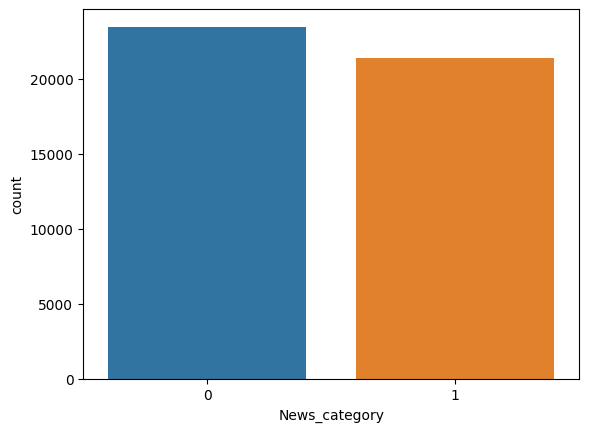

In [10]:
sns.countplot(x='News_category',data =final_data)
plt.show()

Text Preprocessing

In [11]:
def preprocessing(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
final_data['text'] =final_data['text'].apply(preprocessing)

In [13]:
X = final_data['text']
y =final_data['News_category']

In [14]:
X_train ,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,random_state=42,shuffle =True,stratify=final_data['News_category'])

In [15]:
#vectoriser =TfidfVectorizer()
vectoriser = CountVectorizer()
vectoriser.fit(X_train)
X_train =vectoriser.transform(X_train)
X_test =vectoriser.transform(X_test)

In [31]:
def evaluate_model(model,X_train,y_train):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy =accuracy_score(y_pred,y_test)
    print(f'{model}:')
    print('Accuracy score :','{0:.2%}'.format(accuracy))
    cf_matrix =confusion_matrix(y_test,y_pred)

    categories =['Negative','Positive']
    group_names =['True Neg','False Pos','False Neg','True Pos']
    group_percentages =['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues',fmt='')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.title('Confusion Matrix')

In [22]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(4,20,10)]
#max_features =['auto','sqrt']
max_depth =[int(x) for x in np.linspace(10,110,11)]
max_depth.append(None)
#min_samples_split = [2,5,10]
#min_samples_leaf = [1,2,4]
#bootstrap = [True,False]

hyperparameter ={
    'n_estimators': n_estimators,
    #'max_features': max_features,
    'max_depth'   : max_depth,
    #'min_samples_split' : min_samples_split,
    #'min_samples_leaf' : min_samples_leaf,
    #'bootstrap'        : bootstrap
}

In [25]:
gridsearch = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions =hyperparameter, n_iter =100, cv =3, verbose =2, random_state =42,n_jobs =-1)
gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'n_estimators': [4, 5, 7, 9, 11, 12, 14,
                                                         16, 18, 20]},
                   random_state=42, verbose=2)

In [26]:
best =gridsearch.best_params_

In [28]:
RFC = gridsearch.best_estimator_

In [40]:
Logmodel = LogisticRegression()

param_grids ={
    'penalty':['l1','l2'],
    'C': np.logspace(-4,4,20),
    'max_iter':[100,500,1000,1500]
}

In [41]:
log_random = RandomizedSearchCV(estimator = Logmodel, param_distributions =param_grids, n_iter =100, cv =3, verbose =2, random_state =42,n_jobs =-1)
log_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
156 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
156 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: So

RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'max_iter': [100, 500, 1000, 1500],
                                        'penalty': ['l1', 'l2']},
                   random_state=42, verbose=2)

In [42]:
Model =[Logmodel, DecisionTreeClassifier(), RFC, GradientBoostingClassifier()]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression():
Accuracy score : 99.63%


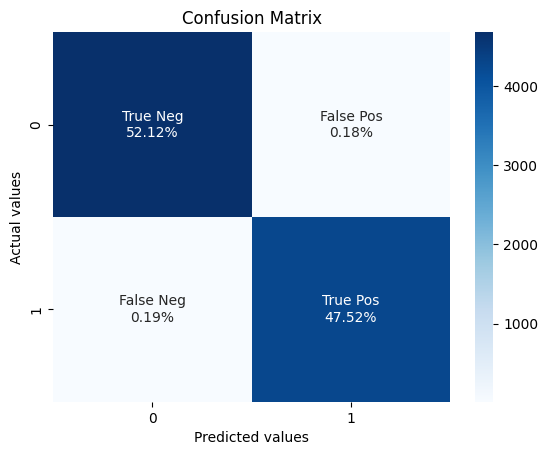

In [43]:
evaluate_model(Model[0],X_train,y_train)

DecisionTreeClassifier():
Accuracy score : 99.64%


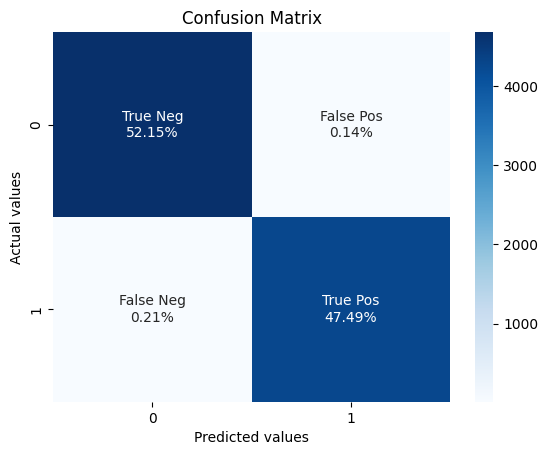

In [48]:
evaluate_model(Model[1],X_train,y_train)

RandomForestClassifier(max_depth=30, n_estimators=20):
Accuracy score : 97.41%


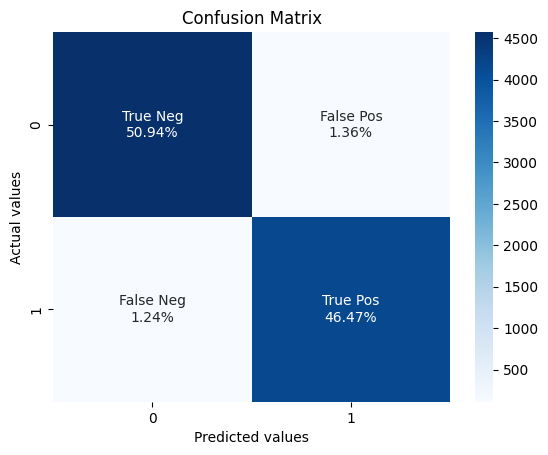

In [32]:
evaluate_model(Model[2],X_train,y_train)

GradientBoostingClassifier():
Accuracy score : 99.59%


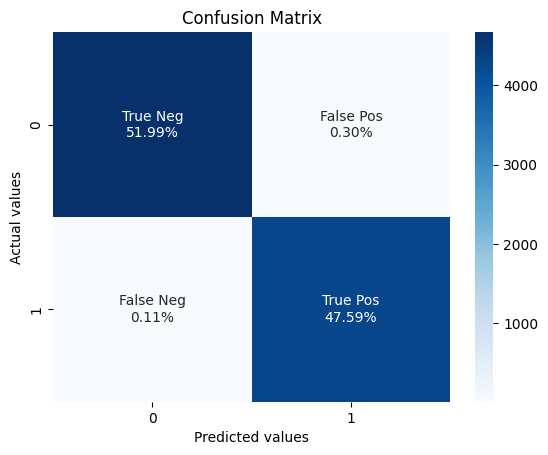

In [50]:
evaluate_model(Model[3],X_train,y_train)

In [44]:
def output_label(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"

In [45]:
def model_testing(news):

    testing ={'text':[news]}
    new_test_data = pd.DataFrame(testing)
    new_test_data['text'] =new_test_data['text'].apply(preprocessing)
    new_x_test = vectoriser.transform(new_test_data['text'])
    predLR = Model[0].predict(new_x_test)
    predDTC = Model[1].predict(new_x_test)
    predRFC = Model[2].predict(new_x_test)
    predGBC = Model[3].predict(new_x_test)

    return print("\nLR Prediction:{} \nDT Prediction:{} \nGBC Prediction:{} \nRFC Prediction:{}".format(
        output_label(predLR[0]),
        output_label(predDTC[0]),
        output_label(predRFC[0]),
        output_label(predGBC[0])))

In [54]:
news = str(input())

Vic Bishop Waking TimesOur reality is carefully constructed by powerful corporate, political and special interest sources in order to covertly sway public opinion. Blatant lies are often televised regarding terrorism, food, war, health, etc. They are fashioned to sway public opinion and condition viewers to accept what have become destructive societal norms.The practice of manipulating and controlling public opinion with distorted media messages has become so common that there is a whole industry formed around this. The entire role of this brainwashing industry is to figure out how to spin information to journalists, similar to the lobbying of government. It is never really clear just how much truth the journalists receive because the news industry has become complacent. The messages that it presents are shaped by corporate powers who often spend millions on advertising with the six conglomerates that own 90% of the media:General Electric (GE), News-Corp, Disney, Viacom, Time Warner, a

In [55]:
model_testing(news)


LR Prediction:Fake News 
DT Prediction:Fake News 
GBC Prediction:Fake News 
RFC Prediction:Fake News
